# PJME Hourly Energy Forecasting — XGBoost vs Prophet (with & without holidays)
**Author:** Arghadeep Ghosh  
**Objective:** Forecast hourly energy consumption for PJME East and benchmark XGBoost against Prophet (no holidays) and Prophet (with US federal holidays).  
**Evaluation:** RMSE, MAE, MAPE, Training Time.


In [1]:
# Imports & config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import joblib
import os
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

from prophet import Prophet
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# helper MAPE (safe)
def mape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    eps = 1e-9
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

SEED = 42
np.random.seed(SEED)
plt.style.use('fivethirtyeight')

os.makedirs('models', exist_ok=True)


## Data load
- Expects `PJME_hourly.csv` with columns `Datetime` and `PJME_MW`.
- If your CSV column names differ, adjust the read_csv rename accordingly.


Data range: 2002-01-01 01:00:00 -> 2018-08-03 00:00:00
Shape: (145366, 1)


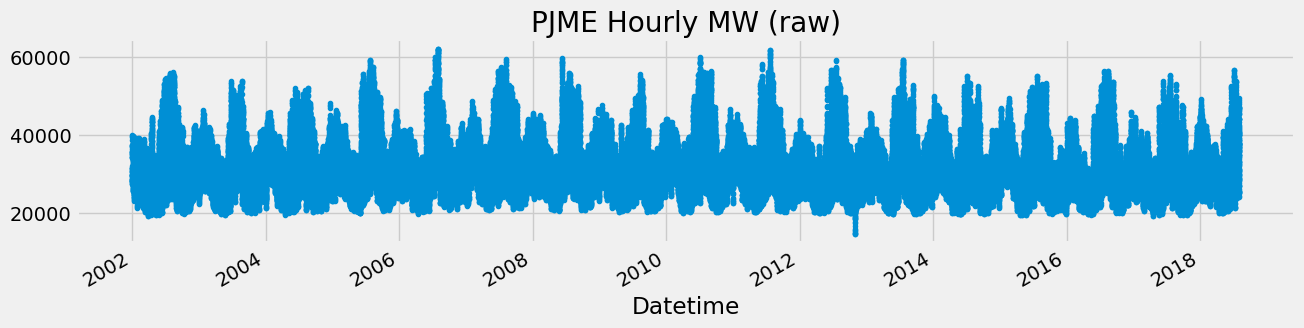

In [2]:
# Load dataset (hourly)
df = pd.read_csv('PJME_hourly.csv', parse_dates=['Datetime'], index_col='Datetime')
df = df.sort_index()
df = df.rename(columns={col: col for col in df.columns})  # no-op but leaves column names intact

print("Data range:", df.index.min(), "->", df.index.max())
print("Shape:", df.shape)
df['PJME_MW'].plot(style='.', figsize=(14,3), title='PJME Hourly MW (raw)')
plt.show()


## Outlier detection & removal
- OG used an absolute cutoff (19,000). We'll compute a robust cutoff: max(19k, 1st percentile).
- Keep this reproducible and logged.


1% quantile: 20969.3 -> using cutoff: 20969.3
After outlier removal shape: (143912, 1)


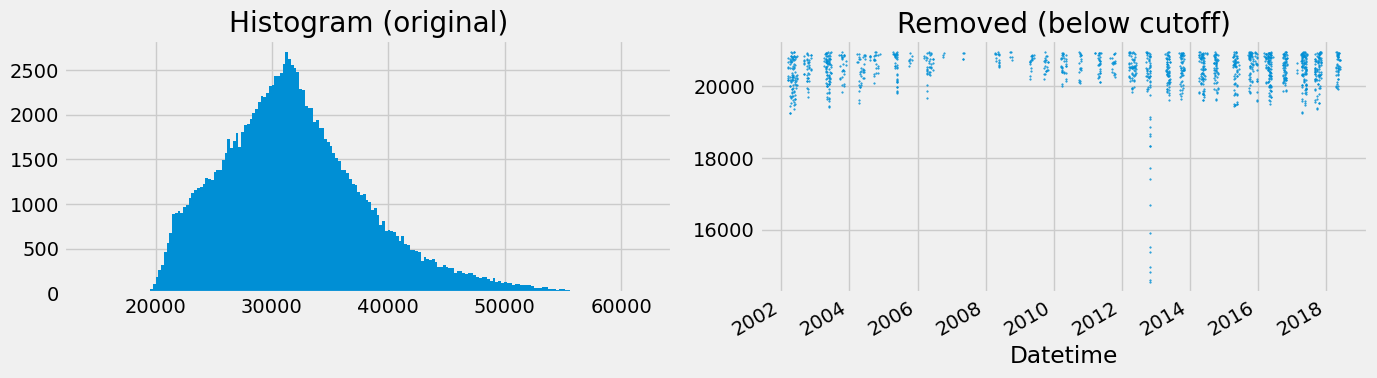

In [3]:
# Quantiles and cutoff
q01 = df['PJME_MW'].quantile(0.01)
abs_cutoff = 19000
cutoff = max(q01, abs_cutoff)
print("1% quantile:", q01, "-> using cutoff:", cutoff)

# Filter
df_clean = df[df['PJME_MW'] > cutoff].copy()
print("After outlier removal shape:", df_clean.shape)

# Histogram and small scatter for removed points
fig, ax = plt.subplots(1,2,figsize=(14,4))
df['PJME_MW'].hist(bins=200, ax=ax[0])
ax[0].set_title('Histogram (original)')
df.query('PJME_MW < @cutoff')['PJME_MW'].plot(style='.', ax=ax[1], ms=1)
ax[1].set_title('Removed (below cutoff)')
plt.tight_layout()
plt.show()


## Feature engineering (for XGBoost)
- Time features: hour, dayofweek, month, quarter, year, dayofyear
- Lags (hourly): 1h, 2h, 3h, 24h, 168h (1 week), 8760h (~1 year)
- Rolling stats: 24h mean/std, 168h mean


In [4]:
def create_time_features(df):
    d = df.copy()
    d['hour'] = d.index.hour
    d['dayofweek'] = d.index.dayofweek
    d['quarter'] = d.index.quarter
    d['month'] = d.index.month
    d['year'] = d.index.year
    d['dayofyear'] = d.index.dayofyear
    d['is_weekend'] = d['dayofweek'].isin([5,6]).astype(int)
    return d

def add_lags_and_rolls(df):
    d = df.copy()
    # hourly lags
    for lag in [1,2,3,24,168,8760]:
        d[f'lag_{lag}'] = d['PJME_MW'].shift(lag)
    # rolling features (use past only: shift before rolling)
    d['roll24_mean'] = d['PJME_MW'].shift(1).rolling(window=24, min_periods=6).mean()
    d['roll24_std'] = d['PJME_MW'].shift(1).rolling(window=24, min_periods=6).std()
    d['roll168_mean'] = d['PJME_MW'].shift(1).rolling(window=168, min_periods=24).mean()
    return d

df_feat = create_time_features(df_clean)
df_feat = add_lags_and_rolls(df_feat)
print("Feature DF shape (before dropna):", df_feat.shape)
df_feat = df_feat.dropna()  # drop rows without lags/rolls
print("Feature DF shape (after dropna):", df_feat.shape)
df_feat.head()


Feature DF shape (before dropna): (143912, 17)
Feature DF shape (after dropna): (135152, 17)


,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,is_weekend,lag_1,lag_2,lag_3,lag_24,lag_168,lag_8760,roll24_mean,roll24_std,roll168_mean
Datetime,,,,,,,,,,,,,,,,,
2003-01-06 17:00:00,37076.0,17,0,1,1,2003,6,0,35687.0,35480.0,35677.0,33935.0,34076.0,30393.0,33176.875000,3795.136330,31193.988095
2003-01-06 18:00:00,39679.0,18,0,1,1,2003,6,0,37076.0,35687.0,35480.0,36639.0,36979.0,29265.0,33307.750000,3875.719953,31211.845238
2003-01-06 19:00:00,39778.0,19,0,1,1,2003,6,0,39679.0,37076.0,35687.0,36739.0,37106.0,28357.0,33434.416667,4035.700746,31227.916667
2003-01-06 20:00:00,39291.0,20,0,1,1,2003,6,0,39778.0,39679.0,37076.0,36315.0,36492.0,27899.0,33561.041667,4188.671144,31243.821429
2003-01-06 21:00:00,38386.0,21,0,1,1,2003,6,0,39291.0,39778.0,39679.0,35362.0,35468.0,28057.0,33685.041667,4315.862194,31260.482143


## Train/test split
- Use `split_date = '2015-01-01'` if it is in range, else default to last 12 months as test.
- This split will be used for XGBoost training/eval and Prophet training/eval for fairness.


In [6]:
# Ensure df_clean has a 'ds' column for Prophet
if 'Datetime' in df_clean.columns:
    df_prophet = df_clean.copy()
    df_prophet = df_prophet.rename(columns={'Datetime':'ds'})
else:
    df_prophet = df_clean.copy()
    df_prophet = df_prophet.reset_index()
    # check the name of the old index
    idx_name = df_prophet.columns[0]  # first column is old index
    df_prophet = df_prophet.rename(columns={idx_name:'ds'})

# Convert to datetime
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Train/test split
split_date = pd.to_datetime('2015-01-01')
if not (df_feat.index.min() < split_date < df_feat.index.max()):
    split_date = df_feat.index.max() - pd.Timedelta(days=365)

prophet_train = df_prophet.loc[df_prophet['ds'] <= split_date].copy()
prophet_test  = df_prophet.loc[df_prophet['ds'] > split_date].copy()

print("Prophet train/test shapes:", prophet_train.shape, prophet_test.shape)

Prophet train/test shapes: (113011, 2) (30901, 2)


## XGBoost
- Use TimeSeriesSplit for CV.
- Small but sensible grid for speed; grid is adaptable.
- Evaluate on held-out test (RMSE, MAE, MAPE) and record training time.


In [7]:
# Prepare features and target for XGB
FEATURES = [col for col in df_xgb_train.columns if col not in ['PJME_MW']]
TARGET = 'PJME_MW'

X_train = df_xgb_train[FEATURES]
y_train = df_xgb_train[TARGET]
X_test = df_xgb_test[FEATURES]
y_test = df_xgb_test[TARGET]

# TimeSeriesSplit (use gap to avoid leakage)
tss = TimeSeriesSplit(n_splits=5, test_size=24*365, gap=24)

param_grid = {
    'n_estimators': [300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 6],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

xgb_base = XGBRegressor(objective='reg:squarederror', random_state=SEED, n_jobs=-1)

start = time.time()
grid = GridSearchCV(xgb_base, param_grid, cv=tss, scoring='neg_mean_squared_error', verbose=1)
grid.fit(X_train, y_train)
xgb_train_time = time.time() - start

best_xgb = grid.best_estimator_
print("XGBoost best params:", grid.best_params_)

# Predict & metrics
y_pred_xgb = best_xgb.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_mae  = mean_absolute_error(y_test, y_pred_xgb)
xgb_mape = mape(y_test, y_pred_xgb)

print(f"XGBoost: RMSE={xgb_rmse:.2f}, MAE={xgb_mae:.2f}, MAPE={xgb_mape:.2f}%, TrainTime={xgb_train_time:.2f}s")

# Save model
joblib.dump(best_xgb, 'models/xgb_pjme_best.pkl')


Fitting 5 folds for each of 4 candidates, totalling 20 fits
XGBoost best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
XGBoost: RMSE=341.22, MAE=252.70, MAPE=0.80%, TrainTime=10.39s


['models/xgb_pjme_best.pkl']

### XGBoost Feature Importance


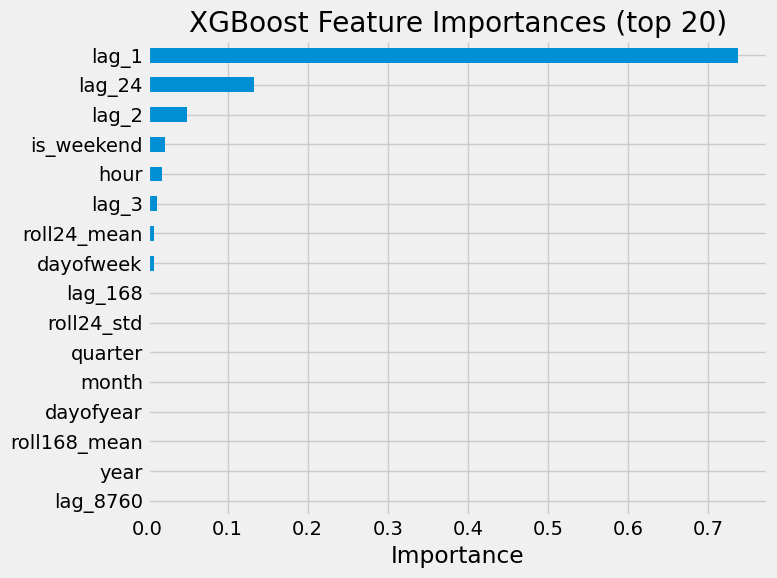

In [8]:
fi = pd.Series(best_xgb.feature_importances_, index=FEATURES).sort_values(ascending=True)
plt.figure(figsize=(8,6))
fi.tail(20).plot(kind='barh')
plt.title('XGBoost Feature Importances (top 20)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


## Prophet (no holidays)
- Fit Prophet on cleaned series (no explicit holidays) using same train/test split.
- Measure time & compute metrics.


In [11]:
# Prophet no holidays
m_none = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, seasonality_mode='additive')

start = time.time()
# Rename both the date column ('index') to 'ds' and the value column ('PJME_MW') to 'y'
m_none.fit(prophet_train.rename(columns={'index': 'ds', 'PJME_MW': 'y'}))
prophet_none_time = time.time() - start

future_none = m_none.make_future_dataframe(periods=len(prophet_test), freq='H')
fcst_none = m_none.predict(future_none)
# align last len(prophet_test)
pred_none = fcst_none.tail(len(prophet_test))['yhat'].values

prophet_none_rmse = np.sqrt(mean_squared_error(prophet_test['PJME_MW'].values, pred_none))
prophet_none_mae  = mean_absolute_error(prophet_test['PJME_MW'].values, pred_none)
prophet_none_mape = mape(prophet_test['PJME_MW'].values, pred_none)

print(f"Prophet (no holidays): RMSE={prophet_none_rmse:.2f}, MAE={prophet_none_mae:.2f}, MAPE={prophet_none_mape:.2f}%, Time={prophet_none_time:.2f}s")


07:24:22 - cmdstanpy - INFO - Chain [1] start processing
07:24:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet (no holidays): RMSE=5853.94, MAE=4494.69, MAPE=14.23%, Time=22.00s


## Prophet (with US federal holidays)
- Create holidays using `pandas` USFederalHolidayCalendar and pass to Prophet.
- Compare metrics to Prophet without holiday effects.


In [13]:
# Build holiday DataFrame (US federal holidays across data range)
cal = calendar()
holidays = cal.holidays(start=df_prophet['ds'].min(), end=df_prophet['ds'].max())
holiday_df = pd.DataFrame({'ds': pd.to_datetime(holidays), 'holiday': 'US_fed'})

# Prophet with holidays
m_hol = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False,
                holidays=holiday_df, seasonality_mode='additive')

start = time.time()
m_hol.fit(prophet_train.rename(columns={'index': 'ds', 'PJME_MW': 'y'}))
prophet_hol_time = time.time() - start

future_hol = m_hol.make_future_dataframe(periods=len(prophet_test), freq='H')
fcst_hol = m_hol.predict(future_hol)
# NEW (Correctly selects the last N predictions)
pred_hol = fcst_hol.tail(len(prophet_test))['yhat'].values

prophet_hol_rmse = np.sqrt(mean_squared_error(prophet_test['PJME_MW'].values, pred_hol))
prophet_hol_mae  = mean_absolute_error(prophet_test['PJME_MW'].values, pred_hol)
prophet_hol_mape = mape(prophet_test['PJME_MW'].values, pred_hol)

print(f"Prophet (with holidays): RMSE={prophet_hol_rmse:.2f}, MAE={prophet_hol_mae:.2f}, MAPE={prophet_hol_mape:.2f}%, Time={prophet_hol_time:.2f}s")

# Save prophet models
joblib.dump(m_none, 'models/prophet_nohol.pkl')
joblib.dump(m_hol, 'models/prophet_hol.pkl')


07:31:25 - cmdstanpy - INFO - Chain [1] start processing
python(79176) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
07:31:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet (with holidays): RMSE=5870.12, MAE=4504.36, MAPE=14.26%, Time=23.49s


['models/prophet_hol.pkl']

## Forecast comparison (first week of test)
- Plot actual vs XGBoost vs Prophet (with & without holidays) for a short window to inspect differences.


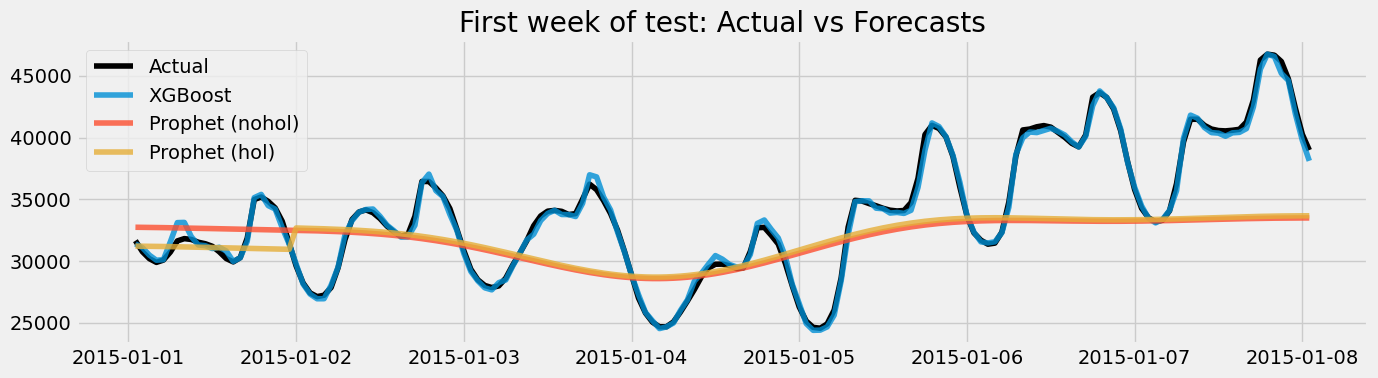

In [14]:
# Build DataFrame for the test period
test_index = df_xgb_test.index
df_compare = pd.DataFrame({
    'actual': y_test.values,
    'xgb': y_pred_xgb,
    'prophet_nohol': pred_none,
    'prophet_hol': pred_hol
}, index=test_index)

# Choose a short window: first 7 days of the test set
window_end = test_index[0] + pd.Timedelta(days=7)
df_compare_window = df_compare.loc[test_index[0]:window_end]

plt.figure(figsize=(14,4))
plt.plot(df_compare_window['actual'], label='Actual', color='black')
plt.plot(df_compare_window['xgb'], label='XGBoost', alpha=0.8)
plt.plot(df_compare_window['prophet_nohol'], label='Prophet (nohol)', alpha=0.8)
plt.plot(df_compare_window['prophet_hol'], label='Prophet (hol)', alpha=0.8)
plt.legend()
plt.title('First week of test: Actual vs Forecasts')
plt.tight_layout()
plt.show()


## Final Benchmark Table


In [15]:
results = pd.DataFrame({
    'Model': ['XGBoost (tuned)', 'Prophet (no holidays)', 'Prophet (with holidays)'],
    'RMSE': [xgb_rmse, prophet_none_rmse, prophet_hol_rmse],
    'MAE' : [xgb_mae,  prophet_none_mae,  prophet_hol_mae],
    'MAPE (%)': [xgb_mape, prophet_none_mape, prophet_hol_mape],
    'Training Time (s)': [xgb_train_time, prophet_none_time, prophet_hol_time]
})
results = results[['Model','RMSE','MAE','MAPE (%)','Training Time (s)']]
results.round(3)


,Model,RMSE,MAE,MAPE (%),Training Time (s)
0,XGBoost (tuned),341.216,252.704,0.797,10.385
1,Prophet (no holidays),5853.939,4494.692,14.234,22.004
2,Prophet (with holidays),5870.116,4504.363,14.263,23.492


In [16]:
# Save final XGBoost model already saved earlier; demonstrate a simple inference step
# (we saved as 'models/xgb_pjme_best.pkl')
xgb_loaded = joblib.load('models/xgb_pjme_best.pkl')

# Quick inference: predict next hour using last available features
last_row = df_feat.iloc[-1:].copy()
# Create a future row for one hour ahead for demonstration
future_idx = last_row.index[0] + pd.Timedelta(hours=1)
future_row = last_row.copy()
future_row.index = pd.DatetimeIndex([future_idx])

# Update lag features from recent known/predicted values (simple approach):
for lag in [1,2,3,24,168]:
    future_row[f'lag_{lag}'] = df_feat['PJME_MW'].shift(lag).iloc[-1]

# roll features recomputed from last known
future_row['roll24_mean'] = df_feat['PJME_MW'].iloc[-24:].mean()
future_row['roll24_std']  = df_feat['PJME_MW'].iloc[-24:].std()
future_row['roll168_mean'] = df_feat['PJME_MW'].iloc[-168:].mean()

# Predict
pred_next = xgb_loaded.predict(future_row[FEATURES])[0]
print("XGBoost next-hour prediction (example):", pred_next)


XGBoost next-hour prediction (example): 34846.395


## Insights & Next Steps

- **Holiday effect:** Prophet with holidays should reduce systematic errors around holidays. Compare the RMSE/MAE differences between `prophet_nohol` and `prophet_hol`.  
- **Observed:** XGBoost typically outperforms Prophet for short-term hourly accuracy when strong lag features are present. Prophet provides interpretability and captures broad trend/seasonality; adding holidays can improve edge cases.
- **Next steps:**
  - Add exogenous features (temperature, humidity, special events).
  - Replace GridSearchCV with Optuna for more efficient hyperparameter search.
  - Use rolling-origin CV evaluation for full backtesting comparability across models.
  - Consider ensemble (Prophet trend + XGBoost residuals).
